# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/neural-network-visualizer')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!pip install livelossplot

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF

# Download Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


# Plot Examples

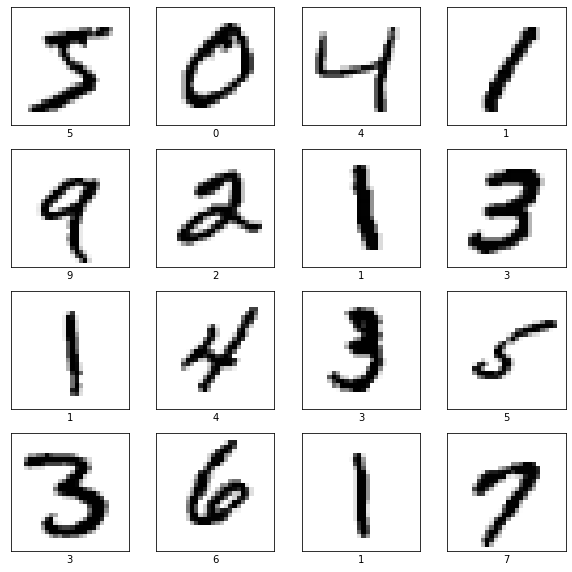

In [4]:
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i], cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Normalize Data

In [5]:
x_train = np.reshape(x_train, (60000, 784))
x_train = x_train / 255.

x_test = np.reshape(x_test, (10000, 784))
x_test = x_test / 255.

# Create a Neural Network Model

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


# Train the Model

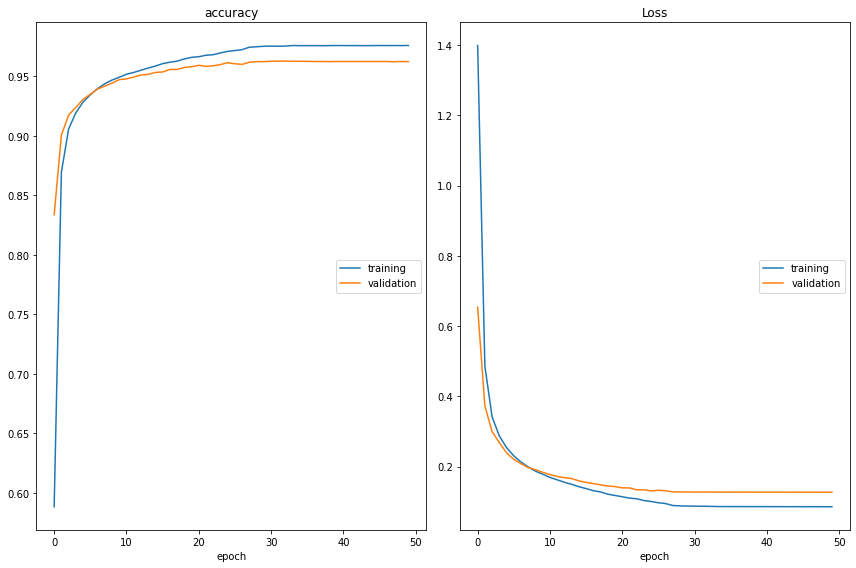

accuracy
	training         	 (min:    0.588, max:    0.976, cur:    0.976)
	validation       	 (min:    0.834, max:    0.963, cur:    0.962)
Loss
	training         	 (min:    0.086, max:    1.399, cur:    0.086)
	validation       	 (min:    0.127, max:    0.654, cur:    0.127)

Epoch 00050: saving model to model.h5
59/59 [==============================] - 1s 20ms/step - loss: 0.0856 - accuracy: 0.9760 - val_loss: 0.1270 - val_accuracy: 0.9624
CPU times: user 1min 13s, sys: 7.62 s, total: 1min 21s
Wall time: 1min


In [7]:
%%time

epochs = 50
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=epochs, batch_size=1024,
    callbacks=callbacks
)

# The ML Server

In [8]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import os
import random
import string

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(model.inputs, [layer.output for layer in model.layers])

_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({'prediction': final_preds, 'image': image.tolist()})
    return 'Welcome to the ml server'

if __name__ == '__main__':
    app.run()


Writing ml_server.py


# Streamlit Web App

In [9]:
%%writefile app.py

import requests
import json
import numpy as np
import streamlit as st
import os
import matplotlib.pyplot as plt

URI = 'http://127.0.0.1:5000'

st.title('Neural Network Visualizer')
st.sidebar.markdown('# Input Image')

if st.button('Get random predictions'):
    response = requests.post(URI, data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28, 28))

    st.sidebar.image(image, width=150)

    for layer, p in enumerate(preds):
        numbers = np.squeeze(np.array(p))

        plt.figure(figsize=(32, 4))

        if layer == 2:
            row = 1
            col = 10
        else:
            row = 2
            col = 16

        for i, number in enumerate(numbers):
            plt.subplot(row, col, i + 1)
            plt.imshow((number * np.ones((8, 8, 3))).astype('float32'), cmap='binary')
            plt.xticks([])
            plt.yticks([])
            if layer == 2:
                plt.xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()

        st.text('Layer {}'.format(layer + 1), )
        st.pyplot()


Writing app.py
